In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_GD1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_GD1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_GD1['SOURCE_KEY'] = df_GD1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_GD1['DATE_TIME'] = pd.to_datetime(df_GD1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD1_with_weather = pd.merge(df_GD1, plant_1_weather, on='DATE_TIME', how='left')

# Mostrar las primeras filas para verificar la unión
df_GD1_with_weather.head()


,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,Solar_Panel_1,0.0,0.0,0.0,6259559.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,Solar_Panel_2,0.0,0.0,0.0,6183645.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,Solar_Panel_3,0.0,0.0,0.0,6987759.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,Solar_Panel_4,0.0,0.0,0.0,7602960.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,Solar_Panel_5,0.0,0.0,0.0,7158964.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


In [3]:
# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD1_with_weather_clean = df_GD1_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD1_with_weather_clean = df_GD1_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

df_GD1_with_weather_clean.head()


,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,Solar_Panel_1,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,Solar_Panel_2,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,Solar_Panel_3,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,Solar_Panel_4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,Solar_Panel_5,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


In [4]:
# Verificar si hay valores nulos
nulos = df_GD1_with_weather_clean.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols = df_GD1_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns #Estp para quitar los floats
df_GD1_with_weather_clean[numerical_cols] = df_GD1_with_weather_clean[numerical_cols].fillna(df_GD1_with_weather_clean[numerical_cols].mean())

# Mostrar las primeras filas después de limpiar los nulos
df_GD1_with_weather_clean.head()

df_GD1_limpio = df_GD1_with_weather_clean


DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


In [5]:
print(nulos)


DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


____

# Entrenamiento

In [7]:
features = ['DAILY_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X = df_GD1_limpio[features]
Y = df_GD1_limpio['DC_POWER']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
model_1 = AdaBoostRegressor()
model_2 = BaggingRegressor()
model_3 = CatBoostRegressor(verbose=0)
model_4 = DecisionTreeRegressor()
model_5 = ElasticNet()
model_6 = ExtraTreesRegressor()
model_7 = KNeighborsRegressor()
model_8 = Lasso()
model_9 = LGBMRegressor(verbose=0)
model_10 = LinearRegression()
model_11 = RandomForestRegressor()
model_12 = Ridge()
model_13 = SVR()
model_14 = XGBRegressor(verbosity=0)
model_15 = SGDRegressor()

In [10]:
model_1.fit(X_train, y_train)

AdaBoostRegressor()

In [11]:
model_2.fit(X_train, y_train)   

BaggingRegressor()

In [12]:
model_3.fit(X_train, y_train)

In [13]:
model_4.fit(X_train, y_train)   

DecisionTreeRegressor()

In [14]:
model_5.fit(X_train, y_train)  

ElasticNet()

In [15]:
model_6.fit(X_train, y_train)

ExtraTreesRegressor()

In [16]:
model_7.fit(X_train, y_train)

KNeighborsRegressor()

In [17]:
model_8.fit(X_train, y_train)

Lasso()

In [18]:
model_9.fit(X_train, y_train)

LGBMRegressor(verbose=0)

In [19]:
model_10.fit(X_train, y_train)

LinearRegression()

In [20]:
model_11.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
model_12.fit(X_train, y_train)

Ridge()

In [22]:
model_13.fit(X_train, y_train)

SVR()

In [23]:
model_14.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
model_15.fit(X_train, y_train)

SGDRegressor()

In [ ]:
# List of models:
models = [model_1, model_2, model_3, model_4, model_5,
          model_6, model_7, model_8, model_9, model_10,
          model_11, model_12, model_13, model_14, model_15]  
models_names = ['AdaBoostRegressor', 
                'BaggingRegressor', 
                'CatBoostRegressor', 
                'DecisionTreeRegressor', 
                'ElasticNet', 
                'ExtraTreesRegressor', 
                'KNeighborsRegressor', 
                'LGBMRegressor', 
                'Lasso', 
                'LinearRegression', 
                'RandomForestRegressor', 
                'Ridge', 
                'SVR', 
                'XGBRegressor',
                'SGDRegressor'] 

# Configurable thresholds
LOW_THRESHOLD = 0.65
MIDDLE_LOW = 0.65
MIDDLE_HIGH = 0.80
HIGH_THRESHOLD = 0.80
OVERFIT_RATIO = 1.20

# Initialize lists for metrics
squared_errors = []
mae_values = []
train_scores = []
test_scores = []
r2_scores = []
ratios = []
rates = []

# Loop through models and calculate metrics
for model, model_name in zip(models, models_names):
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    r2 = r2_score(y_test, y_pred)
    
    # Ratio Difference
    ratio_diff = train_score - test_score
    
    # Evaluate model state
    if train_score <= LOW_THRESHOLD and test_score <= LOW_THRESHOLD:
        state = 'bad'
    elif train_score > test_score * OVERFIT_RATIO:
        state = 'overfit'
    elif train_score == 1.00 and test_score >= 0.85:
        state = 'good but high train score'  # New condition
    elif MIDDLE_LOW < train_score < MIDDLE_HIGH and MIDDLE_LOW < test_score < MIDDLE_HIGH:
        state = 'middle'
    elif HIGH_THRESHOLD <= test_score < 1.00 and HIGH_THRESHOLD <= train_score < 1.00:
        state = 'good'
    elif train_score >= HIGH_THRESHOLD and test_score < HIGH_THRESHOLD:
        state = 'high train, low test'
    else:
        state = 'unknown'
    
    # Append results
    squared_errors.append(f'{mse:.2f}')
    mae_values.append(f'{mae:.2f}')
    train_scores.append(train_score)
    test_scores.append(test_score)
    r2_scores.append(r2)
    ratios.append(f'{ratio_diff * 100:.2f}%')
    rates.append(state)

# Normalize train and test scores as percentages
train_scores_pct = [f'{round(score * 100, 2)}%' for score in train_scores]
test_scores_pct = [f'{round(score * 100, 2)}%' for score in test_scores]

# Create the final DataFrame
model_score = pd.DataFrame({
    'Modelo': models_names,
    'Train score': train_scores_pct,
    'Test score': test_scores_pct,
    'R² score': [f'{round(r2, 2)}' for r2 in r2_scores],
    'Ratio difference': ratios,
    'Evaluate model': rates,
    'Squared error': squared_errors,
    'Mean Absolute Error (MAE)': mae_values
})

# Convert Train score to float for filtering
model_score['Train score (float)'] = model_score['Train score'].str.rstrip('%').astype(float)

# Filter models where Train score is between 0 and 105%
model_score = model_score[(model_score['Train score (float)'] >= 0) & (model_score['Train score (float)'] <= 105)]

# Drop the temporary column
model_score = model_score.drop(columns=['Train score (float)'])

# Sort models by R² score in descending order
model_score = model_score.sort_values(by='R² score', ascending=False)

# Display styled DataFrame
styled_model_score = model_score.style.background_gradient(subset=['R² score'], cmap='viridis')
display(styled_model_score)

# Identify the best model based on R² score
best_model_index = r2_scores.index(max(r2_scores))  # Index of the best model
best_model_name = models_names[best_model_index]
best_model = models[best_model_index]

print(f"\nBest model: {best_model_name}")

# Perform Cross-Validation for the Best Model
cv_folds = 5  # Number of folds for cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring='r2')

# Display Cross-Validation Results
print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Mean R² Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of R² Scores: {np.std(cv_scores):.2f}")

# Append cross-validation scores to a DataFrame for optional analysis
cv_results = pd.DataFrame({
    'Fold': range(1, cv_folds + 1),
    'R² Score': cv_scores
})

# Display the CV results
print("\nCross-Validation Scores per Fold:")
print(cv_results)

,Modelo,Train score,Test score,R² score,Ratio difference,Evaluate model,Squared error,Mean Absolute Error (MAE)
1,BaggingRegressor,99.81%,99.05%,0.99,0.77%,good,154468.62,148.65
2,CatBoostRegressor,99.21%,99.07%,0.99,0.14%,good,149825.48,165.29
3,DecisionTreeRegressor,100.0%,98.74%,0.99,1.26%,good,203615.96,167.13
5,ExtraTreesRegressor,100.0%,98.99%,0.99,1.01%,good,162969.26,149.97
8,Lasso,98.95%,98.88%,0.99,0.07%,good,181218.88,171.38
10,RandomForestRegressor,99.86%,99.08%,0.99,0.78%,good,148858.24,145.67
13,XGBRegressor,99.38%,99.18%,0.99,0.20%,good,133078.79,153.87
7,LGBMRegressor,97.89%,97.91%,0.98,-0.02%,good,338228.77,266.05
9,LinearRegression,97.9%,97.91%,0.98,-0.02%,good,337988.71,265.55
11,Ridge,97.9%,97.91%,0.98,-0.02%,good,338000.56,265.62



Best model: XGBRegressor

Cross-Validation Results for XGBRegressor:
Mean R² Score: 0.99
Standard Deviation of R² Scores: 0.00

Cross-Validation Scores per Fold:
   Fold  R² Score
0     1  0.991122
1     2  0.990036
2     3  0.990415
3     4  0.989781
4     5  0.989633


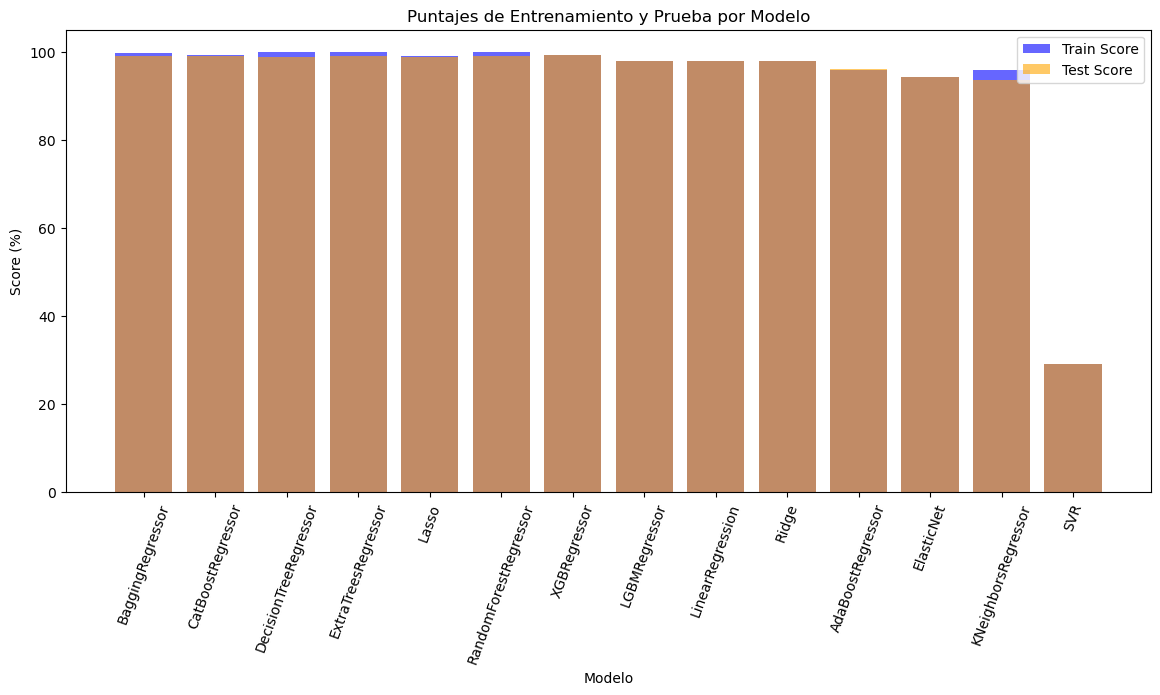

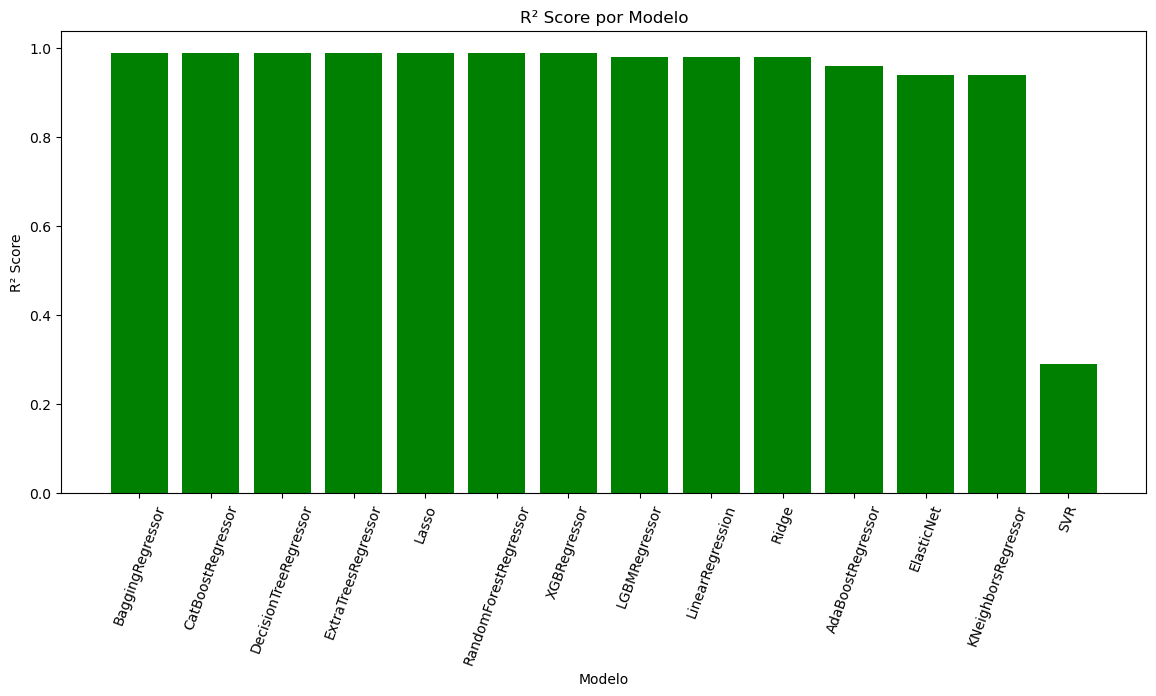

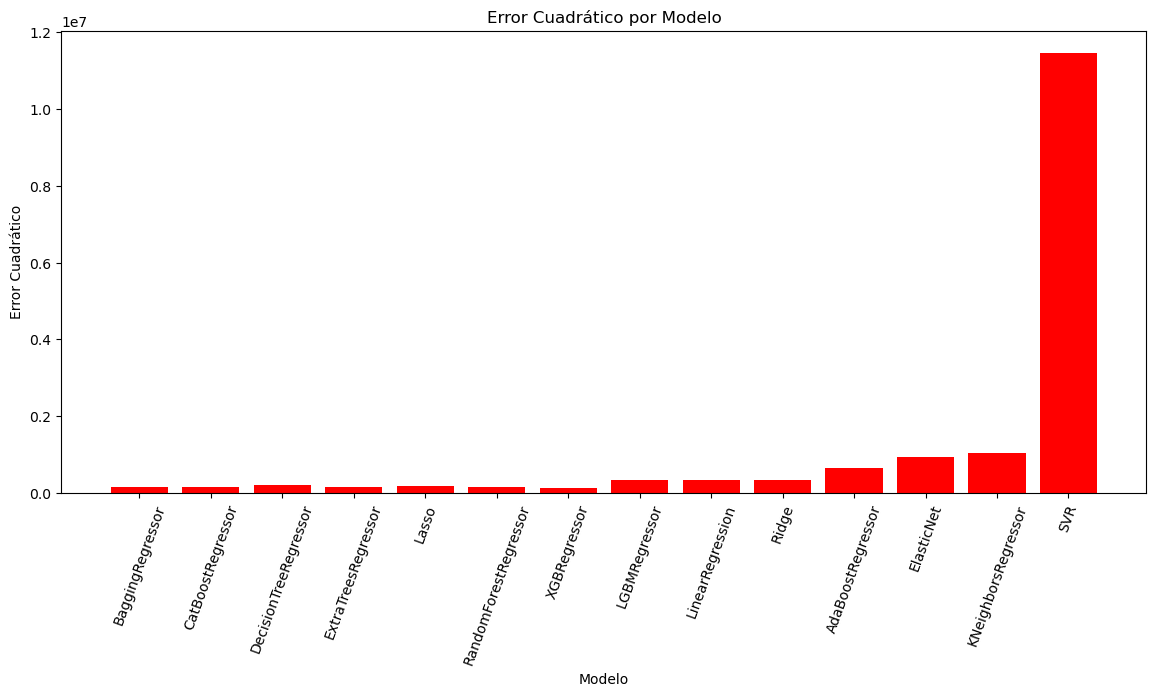

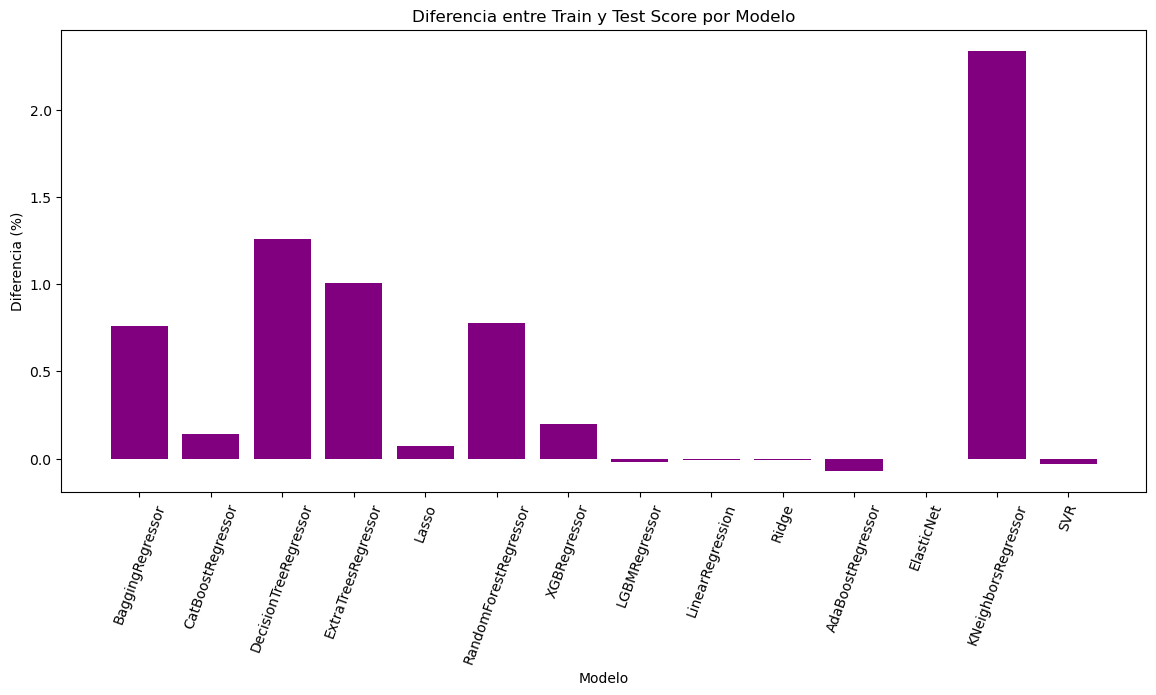

In [26]:
# Gráfica de Barras de los Puntajes de Entrenamiento y Prueba
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Train score'].str.rstrip('%').astype(float), color='blue', alpha=0.6, label='Train Score')
plt.bar(model_score['Modelo'], model_score['Test score'].str.rstrip('%').astype(float), color='orange', alpha=0.6, label='Test Score')
plt.xticks(rotation=70)
plt.title('Puntajes de Entrenamiento y Prueba por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

# Gráfica de R² Score
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['R² score'].astype(float), color='green')
plt.xticks(rotation=70)
plt.title('R² Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('R² Score')
plt.show()

# Gráfica de Errores Cuadráticos (Squared Error)
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Squared error'].str.rstrip('%').astype(float), color='red')
plt.xticks(rotation=70)
plt.title('Error Cuadrático por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Error Cuadrático')
plt.show()

# Gráfica de Diferencia entre Train y Test Score
plt.figure(figsize=(14, 6))
train_test_diff = model_score['Train score'].str.rstrip('%').astype(float) - model_score['Test score'].str.rstrip('%').astype(float)
plt.bar(model_score['Modelo'], train_test_diff, color='purple')
plt.xticks(rotation=70)
plt.title('Diferencia entre Train y Test Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Diferencia (%)')
plt.show()
